# PROJECT 6:

## Deep Learning for Time Series Forecasting

This notebook is a part of my sixth project from the IBM Machine Learning certificate.

#### Abstract
A dataset containing a time series data set of international airline passengers; monthly totals in thousands. Jan 1949 – Dec 1960.

#### Project Objective
The main objective of the project is to build a time series model that will be able to forecast the number of airline passengers for the next 12 months. We will be using the RNN/LSTM method to find the most accurate model.

Source Data: https://www.kaggle.com/ternaryrealm/airlines-passenger-data?select=international-airline-passengers.csv

Source:

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

## Data Exploration

In [1]:
# import libraries

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
os.chdir('data')
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras import initializers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import numpy as np
seed = 1337
np.random.seed(seed)

In [2]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv')
data.head(5)

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
# Explore the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Month                                                                           145 non-null    object 
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [7]:
# We take a look at the first 20 rows
cm = sns.light_palette("green", as_cmap=True)
data.head(24).style.background_gradient(cmap=cm)

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.000000
1,1949-02,118.000000
2,1949-03,132.000000
3,1949-04,129.000000
4,1949-05,121.000000
5,1949-06,135.000000
6,1949-07,148.000000
7,1949-08,148.000000
8,1949-09,136.000000
9,1949-10,119.000000


In [6]:
print(data.describe())
print('-'*40)
print(data.tail())

       International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count                                         144.000000                             
mean                                          280.298611                             
std                                           119.966317                             
min                                           104.000000                             
25%                                           180.000000                             
50%                                           265.500000                             
75%                                           360.500000                             
max                                           622.000000                             
----------------------------------------
                                                 Month  \
140                                            1960-09   
141                                            1960-10   
142        

In [8]:
data.shape

(145, 2)

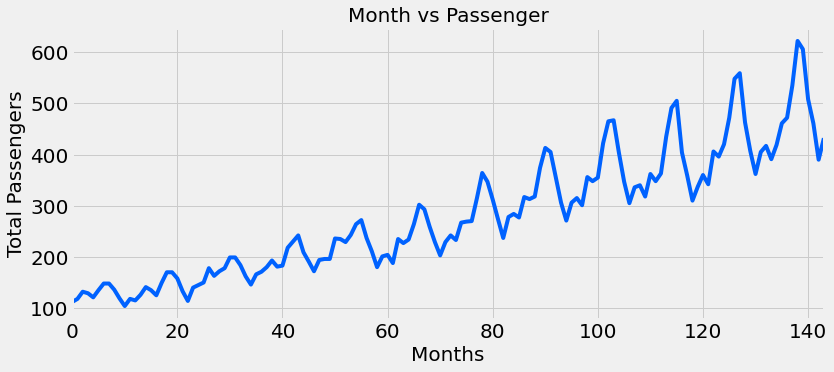

In [11]:
# We make a preliminary visualization of the data 
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])

The plot shows us that the data has a strong upward trend from year to year. There is also a seasonality that is explained by the increase of the number of passengers in the summer periods and decrease in the winter periods. We will now decompose time series data into Trend, Seasonality, and Residual through time series decomposition for a clearification.

In [65]:
# First, we drop the row that has a NaN value. We noticed in data description.
data = data.iloc[:-1 , :]


In [71]:
data.shape

(144, 2)

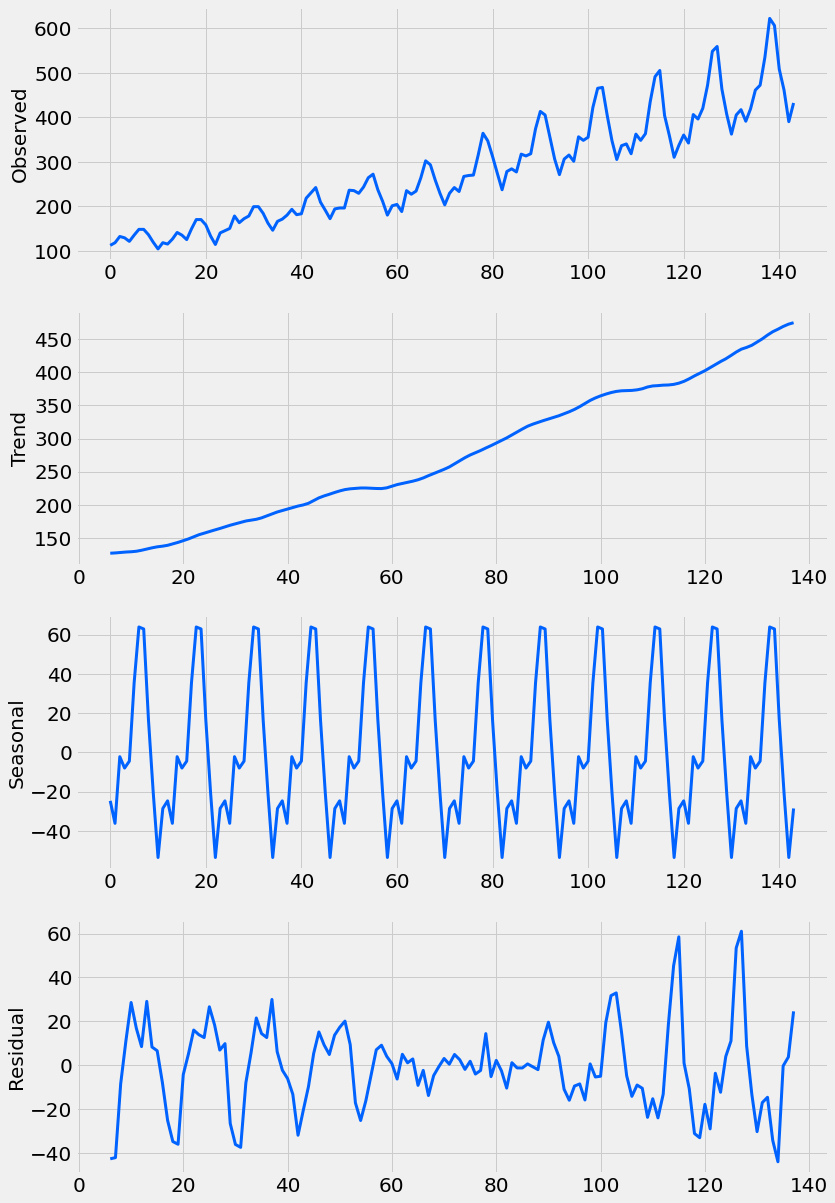

In [67]:
import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

decomposition = seasonal_decompose(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], period=12) 
plot_decompose(decomposition)

We definitely see seasonality in the data. We can also see that the number of customers steadily increases on the Trend plot. We will now determine whether or not the data is stationary.

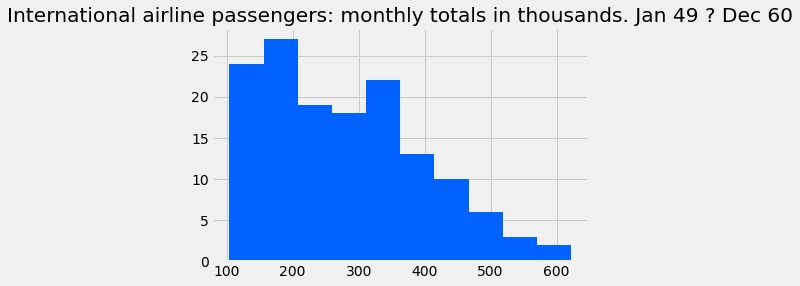

In [68]:
data.hist();

Judging by this histogram, the data looks to be non-stationary due to its abnormal distribution, but we will keep checking. 

In [69]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])
print('P-Value: ', pvalue)

P-Value:  0.9918802434376409


The p-value also informs us that the data is non-stationary. We will scale this data so we can work with it.

## Data Preprocessing

We will now split data into Train and Test sets for model design. 

In [75]:
# We make sure that all values are floats in the passenger column
all_data = data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [76]:
# We split the data
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


In [77]:
# We then perform Min_Max scaling on the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [78]:
import torch
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

We will now create_inout_sequences function

> This function returns a tuple by transforming the raw input data into sequence data to fit training. The number of passengers traveling in the first 12 months predicts the number of passengers in 13 months.
> 
> The first value in tuple: sequence of passengers in 12 months (=features)
> 
> The second value of the tuple: the number of passengers predicted as the number of passengers in 12 months (=target)

In [79]:
train_window = 12
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [80]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

#We take a look at what it looks like
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

## Modeling

Modeling is done using a simple LTSM layer.

* input_size: It corresponds to the number of input sequences. The sequence length is 12, but there is only 1 value per month, i.e. total number of passengers, so the input size is 1.
* hidden_layer_size: Specifies the number of hidden layers.
* output_size: The output size is 1 because the number of items in the output predicts the number of passengers in the next month.

In [81]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [82]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

## LSTM Model 1

In [83]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [84]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [85]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.00082670
epoch:  26 loss: 0.01214420
epoch:  51 loss: 0.00031631
epoch:  76 loss: 0.00005505
epoch: 101 loss: 0.00021154
epoch: 126 loss: 0.00020216
epoch: 151 loss: 0.00013153
epoch: 176 loss: 0.00044937
epoch: 201 loss: 0.00000521
epoch: 226 loss: 0.00038861
epoch: 251 loss: 0.00063193
epoch: 276 loss: 0.00034924
epoch: 301 loss: 0.00045170
epoch: 326 loss: 0.00013206
epoch: 351 loss: 0.00013853
epoch: 376 loss: 0.00000072
epoch: 401 loss: 0.00115239
epoch: 426 loss: 0.00001251
epoch: 451 loss: 0.00003899
epoch: 476 loss: 0.00805935
epoch: 499 loss: 0.00041508


In [86]:
# The test set contains passenger data for the last 12 months. 
# The model is trained to make predictions using sequence length 12. 
# We will predict the last 12 months of data.

fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


The test set is run 12 iterations. At the end of the iteration, the test_inputs list contains 24 entries. The last 12 items are the predicted values for the test set.

In [87]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [88]:
# We check the last 12 predictions
test_inputs[fut_pred:]

[0.5803148746490479,
 0.7998273372650146,
 0.6770046949386597,
 0.4821881949901581,
 0.38985875248908997,
 0.5042966604232788,
 0.8333370685577393,
 1.0621050596237183,
 0.7074356079101562,
 0.47945234179496765,
 0.32752522826194763,
 0.4681207835674286]

Since we normalized the dataset for training, the predicted values are also normalized. We need to transform the normalized predicted values into the actual predicted values. We will use the inverse_transform of the min/max scaler object you used to normalize the data set to transform it to its original values.

In [89]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[463.52163398]
 [513.46071923]
 [485.5185681 ]
 [441.19781436]
 [420.19286619]
 [446.22749025]
 [521.0841831 ]
 [573.12890106]
 [492.4416008 ]
 [440.57540776]
 [406.01198943]
 [437.99747826]]


In [90]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


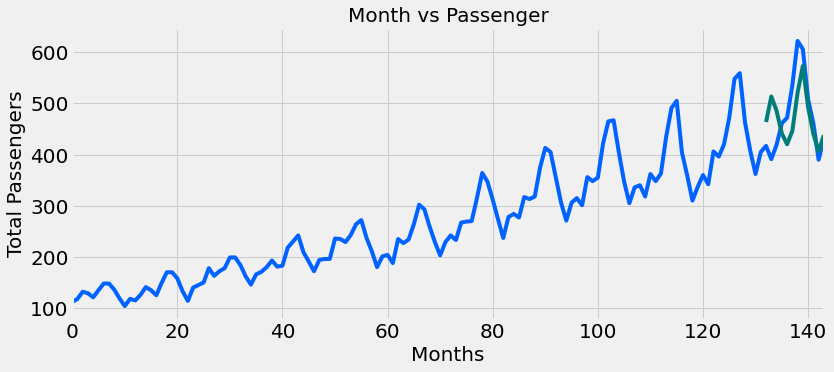

In [91]:
# We now check the results of our model

plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])
plt.plot(x,actual_predictions)


The prediction of the LSTM is indicated by the green line. Although the results are not exact, it is possible to spot an upward trend based on fluctuations in the total number of passengers traveling over the past 12 months. Better performance can be achieved by using a larger number of epochs and a larger number of neurons in the LSTM layer.

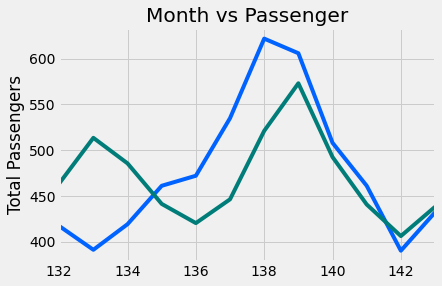

In [92]:
# We take a closer look at LSTM model's performance to get a clearer picture
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

We note that this model performs relatively well but is not as close as we would like so we will try another LSTM with different parameters

## LSTM Model 2

In [93]:
model2 = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [97]:
epochs = 750

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.00101849
epoch:  26 loss: 0.00110241
epoch:  51 loss: 0.00002050
epoch:  76 loss: 0.00001519
epoch: 101 loss: 0.00000623
epoch: 126 loss: 0.00001441
epoch: 151 loss: 0.00037183
epoch: 176 loss: 0.00000889
epoch: 201 loss: 0.00001763
epoch: 226 loss: 0.00000668
epoch: 251 loss: 0.00005322
epoch: 276 loss: 0.00020823
epoch: 301 loss: 0.00047720
epoch: 326 loss: 0.00450349
epoch: 351 loss: 0.00002163
epoch: 376 loss: 0.00000185
epoch: 401 loss: 0.00005303
epoch: 426 loss: 0.00009563
epoch: 451 loss: 0.00027091
epoch: 476 loss: 0.00007555
epoch: 501 loss: 0.00024187
epoch: 526 loss: 0.00007050
epoch: 551 loss: 0.00000518
epoch: 576 loss: 0.00036366
epoch: 601 loss: 0.00000190
epoch: 626 loss: 0.00017117
epoch: 651 loss: 0.00002948
epoch: 676 loss: 0.00000011
epoch: 701 loss: 0.00000422
epoch: 726 loss: 0.00000232
epoch: 749 loss: 0.00001289


In [98]:
# The test set contains passenger data for the last 12 months. 
# The model is trained to make predictions using sequence length 12. 
# We will predict the last 12 months of data.

fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [99]:
model2.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [100]:
# We check the last 12 predictions
test_inputs[fut_pred:]

[0.5202229022979736,
 0.6449031233787537,
 0.5909608006477356,
 0.4494367837905884,
 0.41982898116111755,
 0.596579372882843,
 0.8843753933906555,
 0.7446898818016052,
 0.4627310633659363,
 0.22742390632629395,
 0.2376762330532074,
 0.45494574308395386]

In [101]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[449.85071027]
 [478.21546057]
 [465.94358215]
 [433.74686831]
 [427.01109321]
 [467.22180733]
 [532.695402  ]
 [500.91694811]
 [436.77131692]
 [383.23893869]
 [385.57134302]
 [435.00015655]]


In [102]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


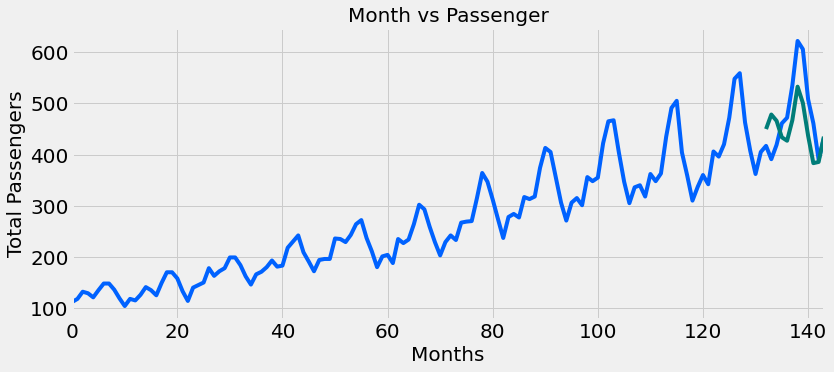

In [103]:
# We now check the results of our model

plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])
plt.plot(x,actual_predictions)


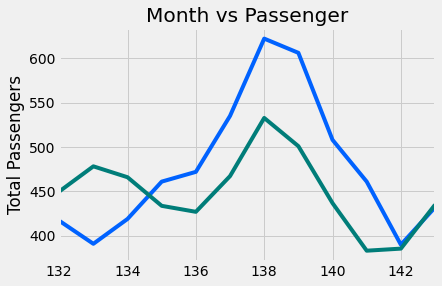

In [104]:
# We take a closer look at LSTM model's performance to get a clearer picture
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

We note that this has performed worse than the first model, but only marginally. Better performance may still be achieved by using a larger number of epochs and a larger number of neurons in the LSTM layer in our next model.

## LSTM Model 3

In [105]:
model3 = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [106]:
epochs = 1000

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%50 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.00000000
epoch:  51 loss: 0.00000113
epoch: 101 loss: 0.00004641
epoch: 151 loss: 0.00006740
epoch: 201 loss: 0.00016403
epoch: 251 loss: 0.00002415
epoch: 301 loss: 0.00001612
epoch: 351 loss: 0.00000011
epoch: 401 loss: 0.00019454
epoch: 451 loss: 0.00000356
epoch: 501 loss: 0.00011584
epoch: 551 loss: 0.00054721
epoch: 601 loss: 0.00000006
epoch: 651 loss: 0.00004221
epoch: 701 loss: 0.00031518
epoch: 751 loss: 0.00004246
epoch: 801 loss: 0.00000023
epoch: 851 loss: 0.00002722
epoch: 901 loss: 0.00025059
epoch: 951 loss: 0.00009005
epoch: 999 loss: 0.00159034


In [107]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [108]:
model3.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [109]:
test_inputs[fut_pred:]

[0.39922386407852173,
 0.3782389760017395,
 0.4926360249519348,
 0.3772776126861572,
 0.3185552954673767,
 0.4563055634498596,
 0.5751075148582458,
 0.705003559589386,
 0.5237030982971191,
 0.3298591375350952,
 0.20833145081996918,
 0.39830756187438965]

In [110]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[422.32342908]
 [417.54936704]
 [443.57469568]
 [417.33065689]
 [403.97132972]
 [435.30951568]
 [462.33695963]
 [491.88830981]
 [450.64245486]
 [406.54295379]
 [378.89540506]
 [422.11497033]]


In [111]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


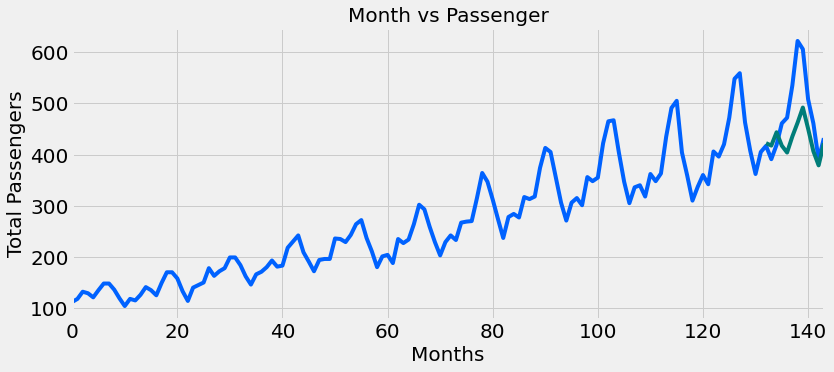

In [113]:
# We now check the results of our model

plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])
plt.plot(x,actual_predictions)


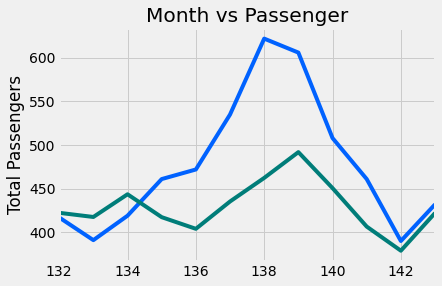

In [114]:
# We take a closer look at LSTM model's performance to get a clearer picture
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

We note that this model performed worse than the first two models, but also only marginally. So, for purposes of this project, we would use Model 1.

## Time Series Analysis with predicted results

We will check whether the predicted results are learned while preserving the trend, seasonality, and residual of the timer series that the original time series has.

In [115]:
data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'][:-train_window]
train_df = pd.DataFrame(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

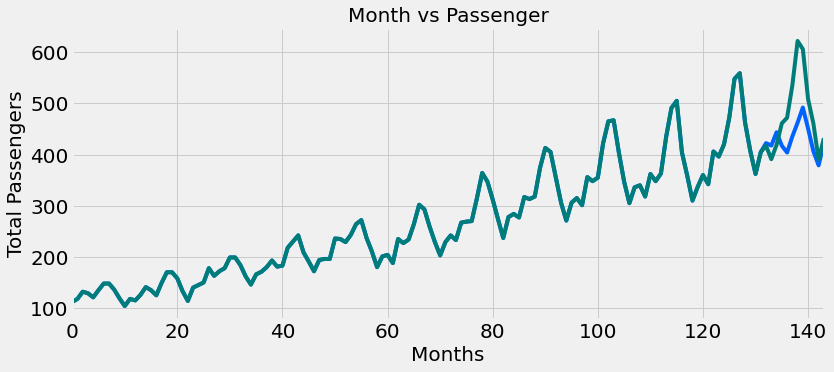

In [116]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'])

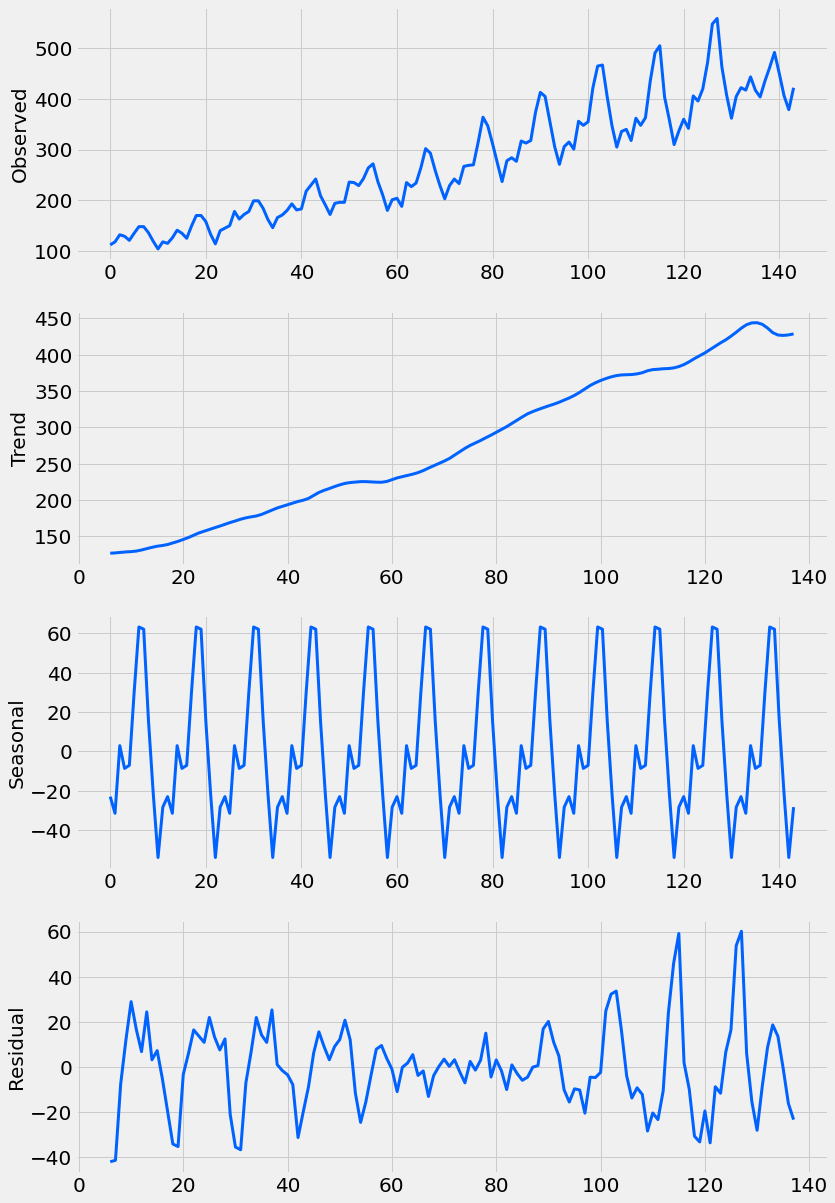

In [117]:
decomposition = seasonal_decompose(new_predict, period=12) 
plot_decompose(decomposition)

## Conclusion

We can confirm that, despite the simple model, it is predicted while well preserving the trend, seasonality, and residual. Model 3 performed the worst out of all three. In general, the predictions of all 3 models are not accurate enough to build a business model on, but they are good enough to understand airline market trends at least. There will be a more in-depth analysis of the project in pdf format. 